In [1]:
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_data = datasets.CIFAR10(root=os.getcwd(),train=True,download=True, transform=transform)
test_data = datasets.CIFAR10(root=os.getcwd(),train=False,download=True, transform=transform)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

mps


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.6)
        )

        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_data):
        conv_1 = self.conv1(input_data)
        conv_2 = self.conv2(conv_1)
        conv_3 = self.conv3(conv_2)
        flat = torch.flatten(conv_3, 1)
        fully1 = self.fc1(flat)
        fully1_relu1 = self.relu(fully1)
        fully2 = self.fc2(fully1_relu1)
        fully2_relu2 = self.relu(fully2)
        fully3 = self.fc3(fully2_relu2)
        out = self.softmax(fully3)
        return out

    def load_model(self, save_path, is_state_dict=False):
        if not is_state_dict:
            saved_model = torch.load(save_path)
            self.load_state_dict(saved_model.state_dict())
        else:
            self.load_state_dict(torch.load(save_path))

    def save_model(self, save_path, is_state_dict=False):
        if is_state_dict:
            torch.save(self.state_dict(), save_path)
        else:
            torch.save(self, save_path)


In [7]:
def train_epoch(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    batch = 0
    correct = 0
    total = 0
    for images,labels in tqdm(train_loader, leave=False, desc="Training Batches"):
        print(images.shape)
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        batch += 1
        output = model.forward(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print("Loss: " + str(total_loss/batch))
    print("Training Accuracy: " + str(correct/total))
    return total_loss/batch, correct/total



In [8]:
def evaluation(model, test_loader, optimizer):
    model.eval()
    total_loss = 0
    batch = 0
    correct = 0
    total = 0
    for images,labels in tqdm(test_loader, leave=False, desc="Testing Batches"):
        images, labels = images.to(device), labels.to(device)
        batch += 1
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predict = torch.max(output.data, 1)
        correct += (predict == labels).sum().item()
        total += labels.size(0)

    print("Loss: " + str(total_loss/batch))
    print("Testing Accuracy: " + str(correct/total))
    return total_loss/batch, correct/total


In [9]:
def train_and_evaluate(number_of_epochs, model, train_loader, val_loader, min_loss=0):
    loss_values = [[],[]]
    acc = [[],[]]
    for epoch in trange(number_of_epochs, desc="Epochs"):
        cur_loss = train_epoch(model, train_loader, optimizer)
        loss_values[0].append(cur_loss[0])
        acc[0].append(cur_loss[1])
        cur_loss_val = evaluation(model, val_loader, optimizer)
        loss_values[1].append(cur_loss_val[0])
        acc[1].append(cur_loss_val[1])
    if cur_loss[0] <= min_loss: return loss_values
    return loss_values, acc

In [10]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_value, accuracy = train_and_evaluate(20, model, train_dataloader, test_dataloader, min_loss=0.2)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/782 [00:00<?, ?it/s]

torch.Size([64, 3, 32, 32])


KeyboardInterrupt: 

In [18]:
# save the training model
path = os.getcwd()+"/cnn.pth"
model.save_model(path)

In [19]:
#load the training model
model = CNN().to(device)
path = os.getcwd()+"/cnn.pth"
model.load_model(path)

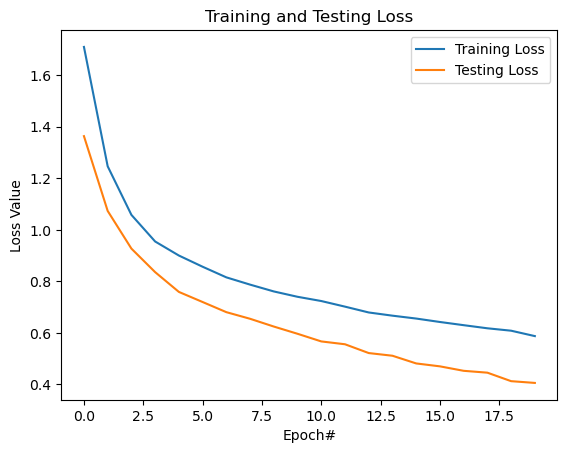

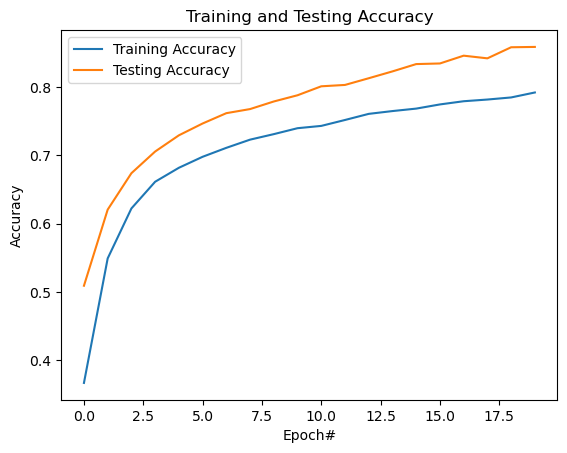

In [19]:
#plot the training and testing loss and accuracy
train_loss = loss_value[0]
test_loss = loss_value[1]
train_accuracy = accuracy[0]
test_accuracy = accuracy[1]

plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Testing Loss")
plt.legend()
plt.xlabel("Epoch#")
plt.ylabel("Loss Value")
plt.title("Training and Testing Loss")
plt.show()
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(test_accuracy, label="Testing Accuracy")
plt.xlabel("Epoch#")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy")
plt.legend()
plt.show()

In [20]:
class_map = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
class_list = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [21]:
prediction = []
true = []
for images,labels in tqdm(test_dataloader, leave=False, desc="Testing Batches"):
    images, labels = images.to(device), labels.to(device)
    output = model.forward(images)
    _, predicted = torch.max(output.data, 1)
    for i in range(labels.shape[0]):
        prediction.append(labels[i].item())
        true.append(predicted[i].item())

Testing Batches:   0%|          | 0/157 [00:00<?, ?it/s]

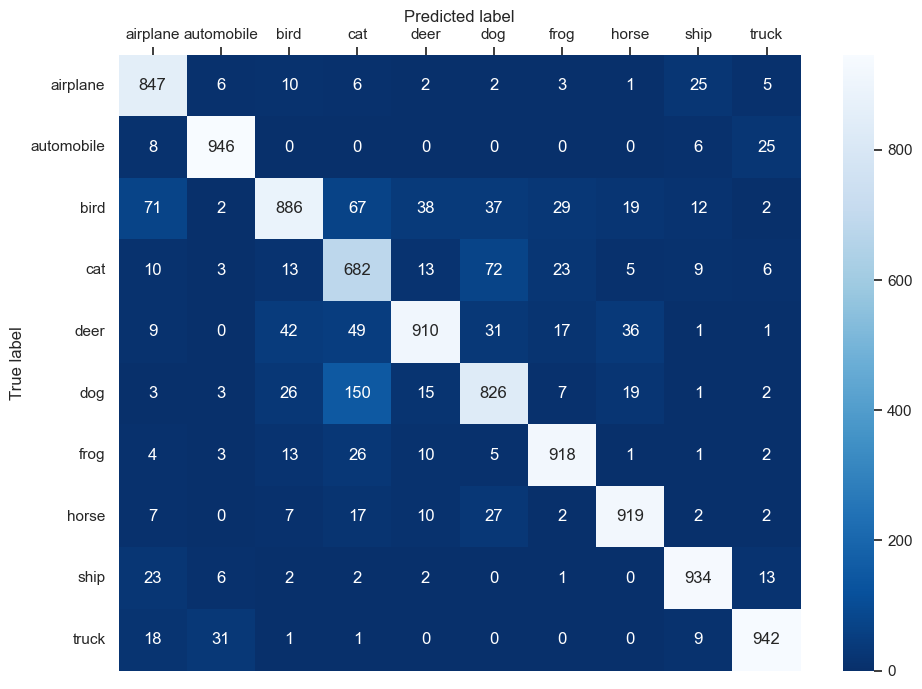

In [30]:
cf_matrix = confusion_matrix(true, prediction)
#print(cf_matrix)
sns.set(rc = {'figure.figsize':(11,8)})
ax = sns.heatmap(cf_matrix,annot=True,fmt='g',xticklabels=class_list,yticklabels=class_list,cmap="Blues_r")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()